In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

# A. Generate Data

In [2]:
#!Rscript generate_data.R --N_data=10000

# B. Train Model

In [3]:
class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.v_thresh_dir = os.path.join(data_dir, 'v_thresh')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.v_thresh_files = [f for f in os.listdir(self.v_thresh_dir) if f.startswith('v_thresh_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)
        
        v_thresh_file = os.path.join(self.v_thresh_dir, self.v_thresh_files[idx])
        v_thresh = np.loadtxt(v_thresh_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(v_thresh, dtype=torch.float32)

In [4]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_indices, test_indices

In [5]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = (torch.sigmoid(self.fc3(x)) + 1)*0.5 # Busquem el rang (0.5, 1)
        return x

In [18]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True):
    model.eval()
    losses_over_train = []
    with torch.no_grad():
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {sum(losses_over_train) / len(train_loader):.4f}')
    
    losses_over_test = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {sum(losses_over_test) / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
        for i, (inputs, targets) in progress_bar:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)
        train_losses.append(sum(losses_over_train) / len(train_loader))
        test_losses.append(sum(losses_over_test) / len(test_loader))
    return train_losses, test_losses

In [19]:
data_dir = 'data'
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt')))

hparams = {"batch_size": 16,
           "learning_rate": 0.001,
           "num_epochs": 100}

train_loader, test_loader, train_indices, test_indices = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_losses, test_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"])

Epoch 1/100: 100%|██████████| 500/500 [00:02<00:00, 216.21it/s]


Epoch [1/100], Running Loss: 0.0310
Train Loss: 0.0273
Test Loss: 0.0279


Epoch 2/100: 100%|██████████| 500/500 [00:02<00:00, 213.71it/s]


Epoch [2/100], Running Loss: 0.0259
Train Loss: 0.0231
Test Loss: 0.0246


Epoch 3/100: 100%|██████████| 500/500 [00:02<00:00, 205.02it/s]


Epoch [3/100], Running Loss: 0.0227
Train Loss: 0.0212
Test Loss: 0.0232


Epoch 4/100: 100%|██████████| 500/500 [00:04<00:00, 103.62it/s]


Epoch [4/100], Running Loss: 0.0210
Train Loss: 0.0194
Test Loss: 0.0219


Epoch 5/100: 100%|██████████| 500/500 [00:04<00:00, 104.78it/s]


Epoch [5/100], Running Loss: 0.0196
Train Loss: 0.0179
Test Loss: 0.0213


Epoch 6/100: 100%|██████████| 500/500 [00:05<00:00, 98.95it/s] 


Epoch [6/100], Running Loss: 0.0183
Train Loss: 0.0166
Test Loss: 0.0210


Epoch 7/100: 100%|██████████| 500/500 [00:04<00:00, 101.22it/s]


Epoch [7/100], Running Loss: 0.0172
Train Loss: 0.0155
Test Loss: 0.0213


Epoch 8/100: 100%|██████████| 500/500 [00:04<00:00, 102.94it/s]


Epoch [8/100], Running Loss: 0.0162
Train Loss: 0.0146
Test Loss: 0.0213


Epoch 9/100: 100%|██████████| 500/500 [00:05<00:00, 94.60it/s] 


Epoch [9/100], Running Loss: 0.0154
Train Loss: 0.0139
Test Loss: 0.0217


Epoch 10/100: 100%|██████████| 500/500 [00:04<00:00, 103.53it/s]


Epoch [10/100], Running Loss: 0.0147
Train Loss: 0.0132
Test Loss: 0.0224


Epoch 11/100: 100%|██████████| 500/500 [00:04<00:00, 102.00it/s]


Epoch [11/100], Running Loss: 0.0141
Train Loss: 0.0124
Test Loss: 0.0228


Epoch 12/100: 100%|██████████| 500/500 [00:04<00:00, 104.96it/s]


Epoch [12/100], Running Loss: 0.0134
Train Loss: 0.0122
Test Loss: 0.0233


Epoch 13/100: 100%|██████████| 500/500 [00:04<00:00, 104.51it/s]


Epoch [13/100], Running Loss: 0.0128
Train Loss: 0.0114
Test Loss: 0.0236


Epoch 14/100: 100%|██████████| 500/500 [00:04<00:00, 103.70it/s]


Epoch [14/100], Running Loss: 0.0123
Train Loss: 0.0107
Test Loss: 0.0242


Epoch 15/100: 100%|██████████| 500/500 [00:04<00:00, 104.12it/s]


Epoch [15/100], Running Loss: 0.0118
Train Loss: 0.0104
Test Loss: 0.0250


Epoch 16/100: 100%|██████████| 500/500 [00:04<00:00, 105.34it/s]


Epoch [16/100], Running Loss: 0.0113
Train Loss: 0.0097
Test Loss: 0.0250


Epoch 17/100: 100%|██████████| 500/500 [00:04<00:00, 105.10it/s]


Epoch [17/100], Running Loss: 0.0108
Train Loss: 0.0094
Test Loss: 0.0261


Epoch 18/100: 100%|██████████| 500/500 [00:04<00:00, 103.77it/s]


Epoch [18/100], Running Loss: 0.0103
Train Loss: 0.0091
Test Loss: 0.0268


Epoch 19/100: 100%|██████████| 500/500 [00:04<00:00, 103.97it/s]


Epoch [19/100], Running Loss: 0.0100
Train Loss: 0.0088
Test Loss: 0.0270


Epoch 20/100: 100%|██████████| 500/500 [00:04<00:00, 103.82it/s]


Epoch [20/100], Running Loss: 0.0095
Train Loss: 0.0084
Test Loss: 0.0274


Epoch 21/100: 100%|██████████| 500/500 [00:04<00:00, 105.75it/s]


Epoch [21/100], Running Loss: 0.0092
Train Loss: 0.0080
Test Loss: 0.0278


Epoch 22/100: 100%|██████████| 500/500 [00:04<00:00, 103.34it/s]


Epoch [22/100], Running Loss: 0.0089
Train Loss: 0.0075
Test Loss: 0.0278


Epoch 23/100: 100%|██████████| 500/500 [00:04<00:00, 104.88it/s]


Epoch [23/100], Running Loss: 0.0086
Train Loss: 0.0073
Test Loss: 0.0291


Epoch 24/100: 100%|██████████| 500/500 [00:04<00:00, 104.41it/s]


Epoch [24/100], Running Loss: 0.0083
Train Loss: 0.0070
Test Loss: 0.0288


Epoch 25/100: 100%|██████████| 500/500 [00:04<00:00, 104.10it/s]


Epoch [25/100], Running Loss: 0.0079
Train Loss: 0.0071
Test Loss: 0.0292


Epoch 26/100: 100%|██████████| 500/500 [00:04<00:00, 105.62it/s]


Epoch [26/100], Running Loss: 0.0077
Train Loss: 0.0071
Test Loss: 0.0297


Epoch 27/100: 100%|██████████| 500/500 [00:04<00:00, 105.95it/s]


Epoch [27/100], Running Loss: 0.0076
Train Loss: 0.0066
Test Loss: 0.0303


Epoch 28/100: 100%|██████████| 500/500 [00:04<00:00, 104.40it/s]


Epoch [28/100], Running Loss: 0.0072
Train Loss: 0.0064
Test Loss: 0.0309


Epoch 29/100: 100%|██████████| 500/500 [00:04<00:00, 105.42it/s]


Epoch [29/100], Running Loss: 0.0070
Train Loss: 0.0064
Test Loss: 0.0316


Epoch 30/100: 100%|██████████| 500/500 [00:04<00:00, 104.60it/s]


Epoch [30/100], Running Loss: 0.0067
Train Loss: 0.0060
Test Loss: 0.0309


Epoch 31/100: 100%|██████████| 500/500 [00:04<00:00, 104.15it/s]


Epoch [31/100], Running Loss: 0.0066
Train Loss: 0.0058
Test Loss: 0.0319


Epoch 32/100: 100%|██████████| 500/500 [00:04<00:00, 103.63it/s]


Epoch [32/100], Running Loss: 0.0066
Train Loss: 0.0059
Test Loss: 0.0312


Epoch 33/100: 100%|██████████| 500/500 [00:04<00:00, 105.07it/s]


Epoch [33/100], Running Loss: 0.0063
Train Loss: 0.0055
Test Loss: 0.0320


Epoch 34/100: 100%|██████████| 500/500 [00:04<00:00, 103.89it/s]


Epoch [34/100], Running Loss: 0.0061
Train Loss: 0.0054
Test Loss: 0.0323


Epoch 35/100: 100%|██████████| 500/500 [00:04<00:00, 103.91it/s]


Epoch [35/100], Running Loss: 0.0060
Train Loss: 0.0054
Test Loss: 0.0320


Epoch 36/100: 100%|██████████| 500/500 [00:04<00:00, 102.72it/s]


Epoch [36/100], Running Loss: 0.0059
Train Loss: 0.0052
Test Loss: 0.0326


Epoch 37/100: 100%|██████████| 500/500 [00:04<00:00, 102.28it/s]


Epoch [37/100], Running Loss: 0.0057
Train Loss: 0.0053
Test Loss: 0.0326


Epoch 38/100: 100%|██████████| 500/500 [00:04<00:00, 103.66it/s]


Epoch [38/100], Running Loss: 0.0056
Train Loss: 0.0053
Test Loss: 0.0337


Epoch 39/100: 100%|██████████| 500/500 [00:04<00:00, 105.24it/s]


Epoch [39/100], Running Loss: 0.0054
Train Loss: 0.0050
Test Loss: 0.0323


Epoch 40/100: 100%|██████████| 500/500 [00:04<00:00, 105.51it/s]


Epoch [40/100], Running Loss: 0.0054
Train Loss: 0.0049
Test Loss: 0.0334


Epoch 41/100: 100%|██████████| 500/500 [00:04<00:00, 104.02it/s]


Epoch [41/100], Running Loss: 0.0053
Train Loss: 0.0046
Test Loss: 0.0332


Epoch 42/100: 100%|██████████| 500/500 [00:04<00:00, 104.51it/s]


Epoch [42/100], Running Loss: 0.0051
Train Loss: 0.0049
Test Loss: 0.0344


Epoch 43/100: 100%|██████████| 500/500 [00:04<00:00, 105.19it/s]


Epoch [43/100], Running Loss: 0.0051
Train Loss: 0.0050
Test Loss: 0.0329


Epoch 44/100: 100%|██████████| 500/500 [00:04<00:00, 105.10it/s]


Epoch [44/100], Running Loss: 0.0050
Train Loss: 0.0045
Test Loss: 0.0337


Epoch 45/100: 100%|██████████| 500/500 [00:04<00:00, 106.04it/s]


Epoch [45/100], Running Loss: 0.0048
Train Loss: 0.0045
Test Loss: 0.0336


Epoch 46/100: 100%|██████████| 500/500 [00:04<00:00, 103.78it/s]


Epoch [46/100], Running Loss: 0.0047
Train Loss: 0.0043
Test Loss: 0.0337


Epoch 47/100: 100%|██████████| 500/500 [00:04<00:00, 102.90it/s]


Epoch [47/100], Running Loss: 0.0047
Train Loss: 0.0045
Test Loss: 0.0337


Epoch 48/100: 100%|██████████| 500/500 [00:04<00:00, 104.15it/s]


Epoch [48/100], Running Loss: 0.0047
Train Loss: 0.0042
Test Loss: 0.0334


Epoch 49/100: 100%|██████████| 500/500 [00:04<00:00, 105.14it/s]


Epoch [49/100], Running Loss: 0.0044
Train Loss: 0.0040
Test Loss: 0.0342


Epoch 50/100: 100%|██████████| 500/500 [00:04<00:00, 105.54it/s]


Epoch [50/100], Running Loss: 0.0044
Train Loss: 0.0041
Test Loss: 0.0337


Epoch 51/100: 100%|██████████| 500/500 [00:04<00:00, 103.26it/s]


Epoch [51/100], Running Loss: 0.0044
Train Loss: 0.0040
Test Loss: 0.0341


Epoch 52/100: 100%|██████████| 500/500 [00:04<00:00, 103.82it/s]


Epoch [52/100], Running Loss: 0.0043
Train Loss: 0.0041
Test Loss: 0.0341


Epoch 53/100: 100%|██████████| 500/500 [00:04<00:00, 103.65it/s]


Epoch [53/100], Running Loss: 0.0043
Train Loss: 0.0040
Test Loss: 0.0343


Epoch 54/100: 100%|██████████| 500/500 [00:04<00:00, 105.11it/s]


Epoch [54/100], Running Loss: 0.0041
Train Loss: 0.0040
Test Loss: 0.0340


Epoch 55/100: 100%|██████████| 500/500 [00:04<00:00, 104.57it/s]


Epoch [55/100], Running Loss: 0.0041
Train Loss: 0.0041
Test Loss: 0.0343


Epoch 56/100: 100%|██████████| 500/500 [00:04<00:00, 105.64it/s]


Epoch [56/100], Running Loss: 0.0041
Train Loss: 0.0039
Test Loss: 0.0346


Epoch 57/100: 100%|██████████| 500/500 [00:04<00:00, 105.66it/s]


Epoch [57/100], Running Loss: 0.0041
Train Loss: 0.0036
Test Loss: 0.0344


Epoch 58/100: 100%|██████████| 500/500 [00:04<00:00, 105.13it/s]


Epoch [58/100], Running Loss: 0.0039
Train Loss: 0.0037
Test Loss: 0.0345


Epoch 59/100: 100%|██████████| 500/500 [00:04<00:00, 103.88it/s]


Epoch [59/100], Running Loss: 0.0039
Train Loss: 0.0036
Test Loss: 0.0344


Epoch 60/100: 100%|██████████| 500/500 [00:04<00:00, 104.69it/s]


Epoch [60/100], Running Loss: 0.0039
Train Loss: 0.0037
Test Loss: 0.0341


Epoch 61/100: 100%|██████████| 500/500 [00:04<00:00, 106.54it/s]


Epoch [61/100], Running Loss: 0.0038
Train Loss: 0.0036
Test Loss: 0.0344


Epoch 62/100: 100%|██████████| 500/500 [00:04<00:00, 105.31it/s]


Epoch [62/100], Running Loss: 0.0038
Train Loss: 0.0035
Test Loss: 0.0349


Epoch 63/100: 100%|██████████| 500/500 [00:04<00:00, 106.11it/s]


Epoch [63/100], Running Loss: 0.0037
Train Loss: 0.0034
Test Loss: 0.0345


Epoch 64/100: 100%|██████████| 500/500 [00:04<00:00, 105.04it/s]


Epoch [64/100], Running Loss: 0.0038
Train Loss: 0.0034
Test Loss: 0.0343


Epoch 65/100: 100%|██████████| 500/500 [00:04<00:00, 104.89it/s]


Epoch [65/100], Running Loss: 0.0036
Train Loss: 0.0033
Test Loss: 0.0345


Epoch 66/100: 100%|██████████| 500/500 [00:04<00:00, 103.17it/s]


Epoch [66/100], Running Loss: 0.0035
Train Loss: 0.0035
Test Loss: 0.0347


Epoch 67/100: 100%|██████████| 500/500 [00:04<00:00, 105.88it/s]


Epoch [67/100], Running Loss: 0.0036
Train Loss: 0.0035
Test Loss: 0.0346


Epoch 68/100: 100%|██████████| 500/500 [00:04<00:00, 106.85it/s]


Epoch [68/100], Running Loss: 0.0036
Train Loss: 0.0034
Test Loss: 0.0350


Epoch 69/100: 100%|██████████| 500/500 [00:02<00:00, 209.10it/s]


Epoch [69/100], Running Loss: 0.0035
Train Loss: 0.0033
Test Loss: 0.0348


Epoch 70/100: 100%|██████████| 500/500 [00:02<00:00, 217.30it/s]


Epoch [70/100], Running Loss: 0.0034
Train Loss: 0.0032
Test Loss: 0.0350


Epoch 71/100: 100%|██████████| 500/500 [00:02<00:00, 217.84it/s]


Epoch [71/100], Running Loss: 0.0034
Train Loss: 0.0031
Test Loss: 0.0343


Epoch 72/100: 100%|██████████| 500/500 [00:02<00:00, 193.97it/s]


Epoch [72/100], Running Loss: 0.0033
Train Loss: 0.0032
Test Loss: 0.0350


Epoch 73/100: 100%|██████████| 500/500 [00:02<00:00, 190.97it/s]


Epoch [73/100], Running Loss: 0.0034
Train Loss: 0.0030
Test Loss: 0.0345


Epoch 74/100: 100%|██████████| 500/500 [00:02<00:00, 186.83it/s]


Epoch [74/100], Running Loss: 0.0033
Train Loss: 0.0032
Test Loss: 0.0346


Epoch 75/100: 100%|██████████| 500/500 [00:02<00:00, 185.50it/s]


Epoch [75/100], Running Loss: 0.0033
Train Loss: 0.0032
Test Loss: 0.0351


Epoch 76/100: 100%|██████████| 500/500 [00:04<00:00, 103.99it/s]


Epoch [76/100], Running Loss: 0.0033
Train Loss: 0.0031
Test Loss: 0.0345


Epoch 77/100: 100%|██████████| 500/500 [00:02<00:00, 194.90it/s]


Epoch [77/100], Running Loss: 0.0032
Train Loss: 0.0031
Test Loss: 0.0347


Epoch 78/100: 100%|██████████| 500/500 [00:02<00:00, 193.87it/s]


Epoch [78/100], Running Loss: 0.0032
Train Loss: 0.0031
Test Loss: 0.0348


Epoch 79/100: 100%|██████████| 500/500 [00:02<00:00, 188.56it/s]


Epoch [79/100], Running Loss: 0.0032
Train Loss: 0.0031
Test Loss: 0.0359


Epoch 80/100: 100%|██████████| 500/500 [00:03<00:00, 157.48it/s]


Epoch [80/100], Running Loss: 0.0032
Train Loss: 0.0030
Test Loss: 0.0347


Epoch 81/100: 100%|██████████| 500/500 [00:05<00:00, 98.57it/s] 


Epoch [81/100], Running Loss: 0.0031
Train Loss: 0.0031
Test Loss: 0.0341


Epoch 82/100: 100%|██████████| 500/500 [00:04<00:00, 119.92it/s]


Epoch [82/100], Running Loss: 0.0030
Train Loss: 0.0031
Test Loss: 0.0348


Epoch 83/100: 100%|██████████| 500/500 [00:03<00:00, 166.25it/s]


Epoch [83/100], Running Loss: 0.0031
Train Loss: 0.0029
Test Loss: 0.0353


Epoch 84/100: 100%|██████████| 500/500 [00:03<00:00, 126.97it/s]


Epoch [84/100], Running Loss: 0.0031
Train Loss: 0.0031
Test Loss: 0.0351


Epoch 85/100: 100%|██████████| 500/500 [00:05<00:00, 95.47it/s] 


Epoch [85/100], Running Loss: 0.0031
Train Loss: 0.0028
Test Loss: 0.0346


Epoch 86/100: 100%|██████████| 500/500 [00:04<00:00, 105.90it/s]


Epoch [86/100], Running Loss: 0.0029
Train Loss: 0.0027
Test Loss: 0.0348


Epoch 87/100: 100%|██████████| 500/500 [00:04<00:00, 107.49it/s]


Epoch [87/100], Running Loss: 0.0030
Train Loss: 0.0029
Test Loss: 0.0353


Epoch 88/100: 100%|██████████| 500/500 [00:04<00:00, 105.38it/s]


Epoch [88/100], Running Loss: 0.0029
Train Loss: 0.0028
Test Loss: 0.0351


Epoch 89/100: 100%|██████████| 500/500 [00:04<00:00, 101.54it/s]


Epoch [89/100], Running Loss: 0.0029
Train Loss: 0.0027
Test Loss: 0.0350


Epoch 90/100: 100%|██████████| 500/500 [00:03<00:00, 128.53it/s]


Epoch [90/100], Running Loss: 0.0029
Train Loss: 0.0028
Test Loss: 0.0347


Epoch 91/100: 100%|██████████| 500/500 [00:02<00:00, 197.31it/s]


Epoch [91/100], Running Loss: 0.0029
Train Loss: 0.0028
Test Loss: 0.0351


Epoch 92/100: 100%|██████████| 500/500 [00:02<00:00, 196.50it/s]


Epoch [92/100], Running Loss: 0.0029
Train Loss: 0.0027
Test Loss: 0.0346


Epoch 93/100: 100%|██████████| 500/500 [00:02<00:00, 199.40it/s]


Epoch [93/100], Running Loss: 0.0028
Train Loss: 0.0026
Test Loss: 0.0350


Epoch 94/100: 100%|██████████| 500/500 [00:02<00:00, 187.48it/s]


Epoch [94/100], Running Loss: 0.0029
Train Loss: 0.0027
Test Loss: 0.0348


Epoch 95/100: 100%|██████████| 500/500 [00:02<00:00, 175.84it/s]


Epoch [95/100], Running Loss: 0.0029
Train Loss: 0.0027
Test Loss: 0.0348


Epoch 96/100: 100%|██████████| 500/500 [00:02<00:00, 187.46it/s]


Epoch [96/100], Running Loss: 0.0028
Train Loss: 0.0027
Test Loss: 0.0352


Epoch 97/100: 100%|██████████| 500/500 [00:02<00:00, 187.35it/s]


Epoch [97/100], Running Loss: 0.0028
Train Loss: 0.0028
Test Loss: 0.0345


Epoch 98/100: 100%|██████████| 500/500 [00:02<00:00, 186.94it/s]


Epoch [98/100], Running Loss: 0.0028
Train Loss: 0.0027
Test Loss: 0.0351


Epoch 99/100: 100%|██████████| 500/500 [00:02<00:00, 193.93it/s]


Epoch [99/100], Running Loss: 0.0028
Train Loss: 0.0026
Test Loss: 0.0351


Epoch 100/100: 100%|██████████| 500/500 [00:02<00:00, 192.57it/s]


Epoch [100/100], Running Loss: 0.0027
Train Loss: 0.0026
Test Loss: 0.0350


# Evaluate Model

In [8]:
losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)

Train Loss: 0.0032
Test Loss: 0.0296


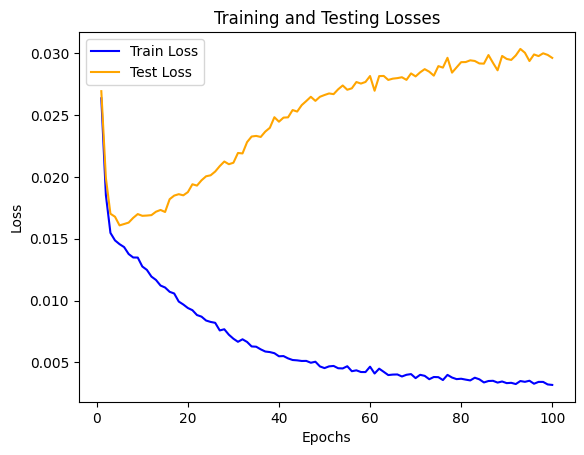

In [9]:
epochs = range(1, len(train_losses) + 1)

# Plot both training and testing losses
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='orange')

# Adding titles and labels
plt.title('Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
# Show the plot
plt.show()

## v distribution

### Training Data

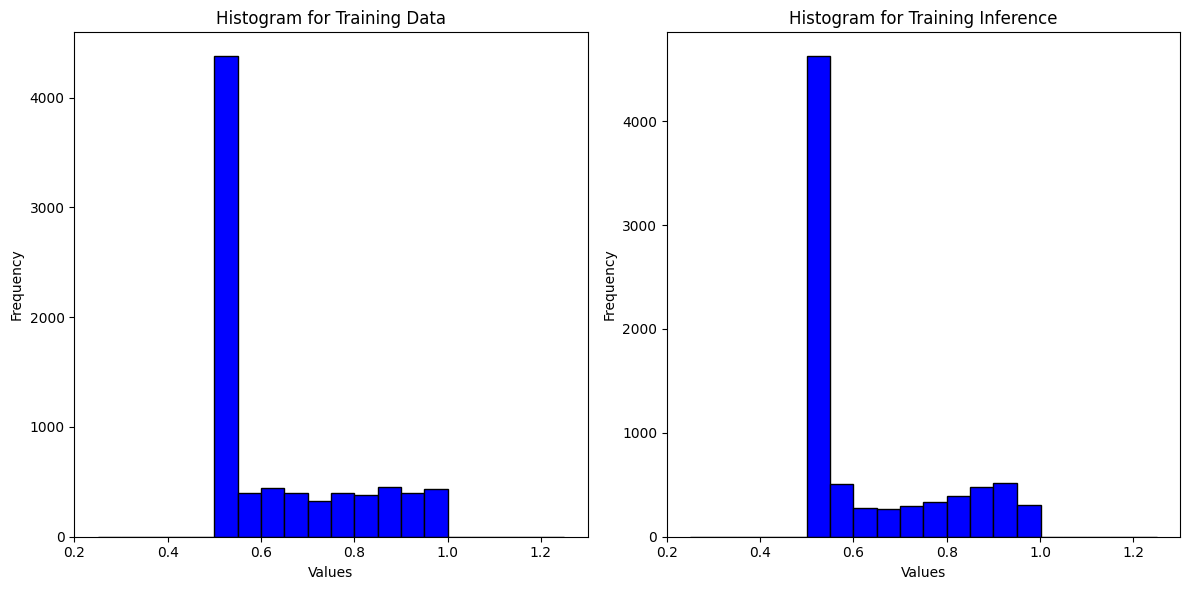

In [10]:
model.eval()

with torch.no_grad():
    train_loader_v = []
    train_infer_v = []
    for inputs, targets in train_loader:
        train_loader_v += targets.numpy().squeeze().tolist()
        train_infer_v += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

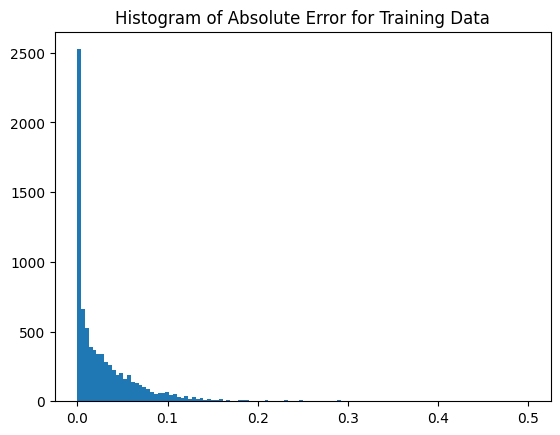

In [11]:
plt.hist(np.abs(np.array(train_loader_v) - np.array(train_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Training Data")
plt.show()

### Test Data

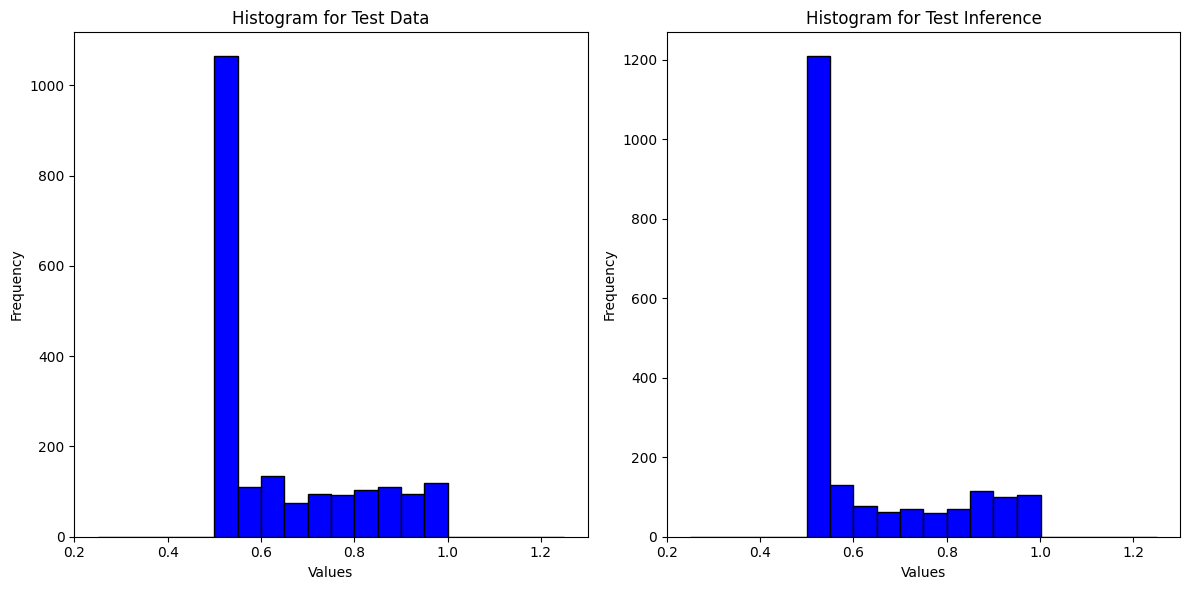

In [12]:
model.eval()

with torch.no_grad():
    test_loader_v = []
    test_infer_v = []
    for inputs, targets in test_loader:
        test_loader_v += targets.numpy().squeeze().tolist()
        test_infer_v += model(inputs).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

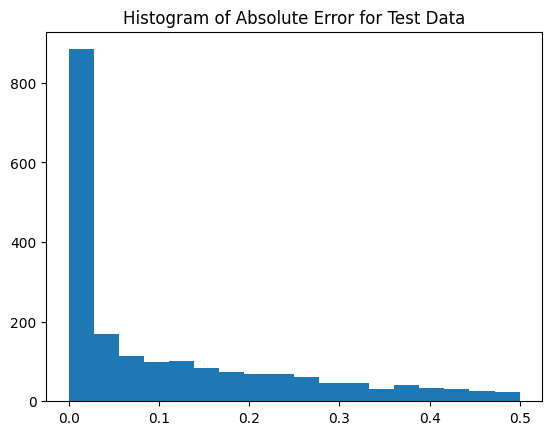

In [13]:
plt.hist(np.abs(np.array(test_loader_v) - np.array(test_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Test Data")
plt.show()

## FDR and TPR

In [14]:
data_dir = 'data'
phi_dir = os.path.join(data_dir, 'Phi_mat')
true_actives_dir = os.path.join(data_dir, 'true_actives')

phi_data = [np.loadtxt(os.path.join(phi_dir, f)) 
            for f in os.listdir(phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
true_actives_data = [np.loadtxt(os.path.join(true_actives_dir, f), dtype=int) - 1  # We substract 1 as they are R indices (starting from 1)
                     for f in os.listdir(true_actives_dir) if f.startswith('true_actives_') and f.endswith('.txt')]

FDRs = []  # or FDPs
TPRs = []  # or TPPs
for phi, true_actives in zip(phi_data, true_actives_data):
    with torch.no_grad():   
        v = model(torch.Tensor(phi)).numpy()[0]
    selected = np.where(phi > v)[0]
    selected_actives = np.intersect1d(selected, true_actives, assume_unique=True)
    selected_null = np.setdiff1d(selected, selected_actives, assume_unique=True)
    FDRs.append(len(selected_null)/max(len(selected), 1))
    TPRs.append(len(selected_actives)/max(len(true_actives), 1))

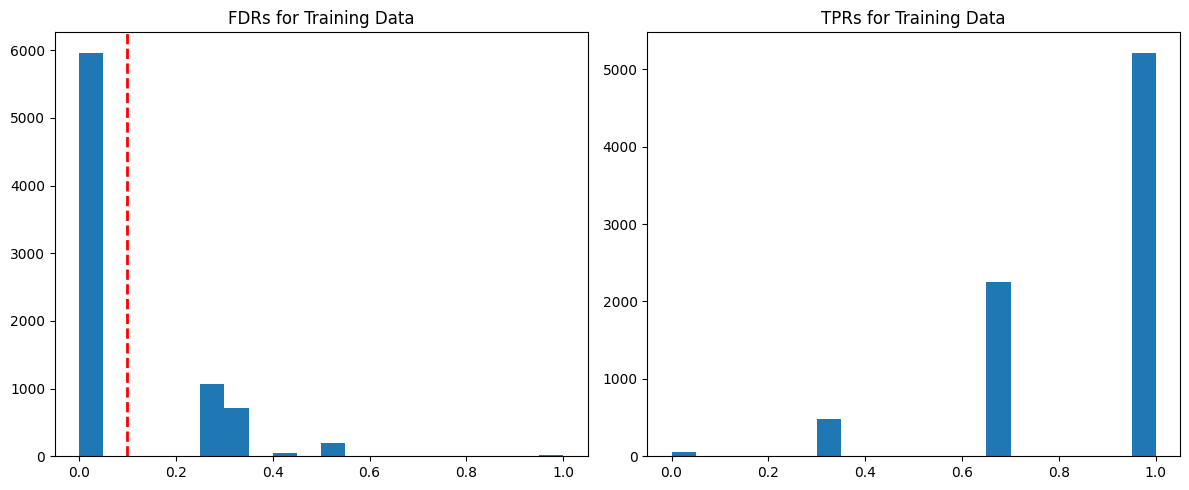

In [15]:
bins = np.arange(0, 1.05, 0.05)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(np.array(FDRs)[train_indices], bins=bins)
axs[0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0].set_title("FDRs for Training Data")

axs[1].hist(np.array(TPRs)[train_indices], bins=bins)
axs[1].set_title("TPRs for Training Data")

plt.tight_layout()
plt.show()

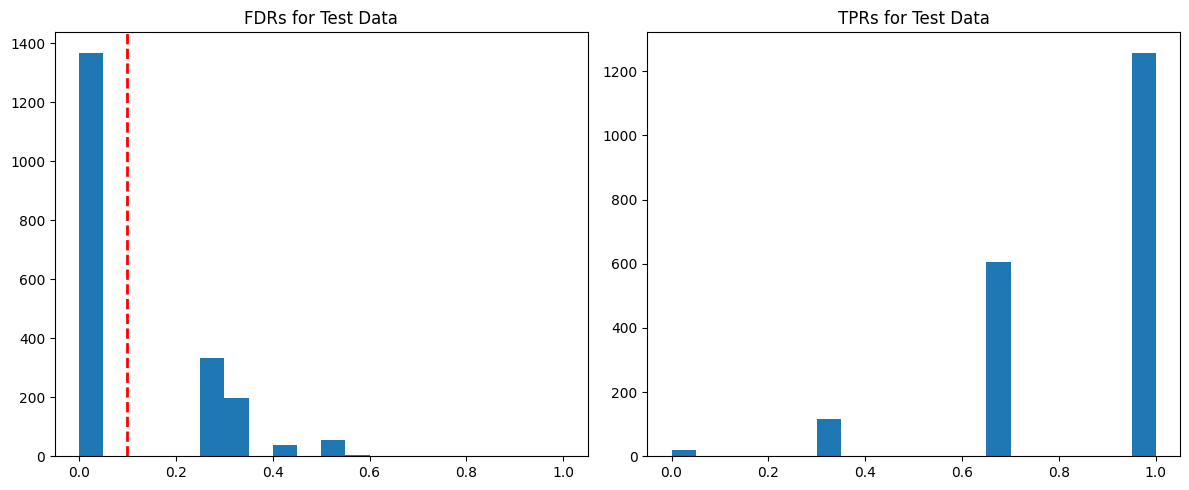

In [16]:
bins = np.arange(0, 1.05, 0.05)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(np.array(FDRs)[test_indices], bins=bins)
axs[0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0].set_title("FDRs for Test Data")

axs[1].hist(np.array(TPRs)[test_indices], bins=bins)
axs[1].set_title("TPRs for Test Data")

plt.tight_layout()
plt.show()